# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from scratch instead of using any pre-existing libraries to do so:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# IMDb reviews URL
url = 'https://www.imdb.com/title/tt15239678/reviews?ref_=tt_urv'

def fetch_data(url):
    """
    Function to fetch data from the URL using requests.
    """
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print("Failed to fetch data from URL:", url)
        return None

def preprocess_text(text):
    """
    Function for text preprocessing.
    """
    text = text.lower()
    text = re.sub('<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [Word(word).lemmatize() for word in tokens if word not in stop_words]
    return tokens

def extract_reviews(url):
    """
    Function to extract reviews from IMDb page using BeautifulSoup.
    """
    html_content = fetch_data(url)
    if html_content:
        soup = BeautifulSoup(html_content, 'html.parser')
        reviews = soup.find_all("div", class_="text")
        return [review.get_text() for review in reviews]
    else:
        return None

# Fetch reviews from IMDb
reviews = extract_reviews(url)

# Create DataFrame from the collected data
df = pd.DataFrame(reviews, columns=['Review'])

# Apply text preprocessing to 'Review' column
df['Cleaned Review'] = df['Review'].apply(preprocess_text)

# Function to calculate n-gram frequencies
def calculate_ngram_frequencies(tokens, n):
    """
    Function to calculate n-gram frequencies.
    """
    ngrams = list(nltk.ngrams(tokens, n))
    frequency_dist = nltk.FreqDist(ngrams)
    return frequency_dist

# Apply functions to calculate frequencies and probabilities
df['Trigram Frequencies'] = df['Cleaned Review'].apply(lambda x: calculate_ngram_frequencies(x, 3))
df['Bigram Frequencies'] = df['Cleaned Review'].apply(lambda x: calculate_ngram_frequencies(x, 2))

# Display the DataFrame
print(df.head(100))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                               Review  \
0   Phenomenal stuff. I'll probably calm down tomo...   
1   This is what Hollywood needs. A great story wi...   
2   This is the kind of movie that is impossible t...   
3   A monumental piece of cinema. And combined wit...   
4   I have to start by saying that I absolutely lo...   
5   Had the pleasure to watch this film in an earl...   
6   If you liked or loved the first one, the same ...   
7   "Dune" has been successfully put to the big sc...   
8   This was a perfect sequel to Denis' part one. ...   
9   We have waited many, many years for a movie of...   
10  In the quiet embrace of ink and page, a story ...   
11  Paul has to prove himself to both Chani and Th...   
12  As with the first film, the production was bea...   
13  I just got out of an early access showing and ...   
14  As an avid movie fan I see plenty of movies, m...   
15  Saw an early screening of this film at the Til...   
16  Dune: Part Two is simply De

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any pre-existing libraries to do so.

In [ ]:
import requests
from bs4 import BeautifulSoup
import math

# Function to fetch data from a URL using BeautifulSoup
def fetch_data(url):
    """
    Fetch HTML content from the URL using requests.
    """
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print("Failed to fetch data from URL:", url)
        return None

# IMDb reviews URL
url = 'https://www.imdb.com/title/tt15239678/reviews?ref_=tt_urv'

# Function to extract reviews from IMDb page using BeautifulSoup
def extract_reviews(url):
    """
    Extract text content of reviews from IMDb page.
    """
    html_content = fetch_data(url)
    if html_content:
        soup = BeautifulSoup(html_content, 'html.parser')
        reviews = soup.find_all("div", class_="text")
        return [review.get_text() for review in reviews]
    else:
        return None

# Fetch reviews from IMDb
reviews = extract_reviews(url)

# Preprocess reviews
preprocessed_reviews = [review.lower().replace('<br/>', ' ') for review in reviews]

# Define query
query = "An Outstanding movie with a outstanding visuals and best character "
query = query.lower()

# Calculate TF-IDF values for the query
query_words = query.split()
doc_freq = {}
for doc in preprocessed_reviews:
    for word in set(query_words):
        if word in doc:
            doc_freq[word] = doc_freq.get(word, 0) + 1

# Calculate cosine similarity scores
cosine_scores = []

# Calculate cosine similarity scores between query and documents
for i, doc in enumerate(preprocessed_reviews):
    words = doc.split()
    tfidf_values = [words.count(word) / len(words) * math.log(len(preprocessed_reviews) / (1 + doc_freq.get(word, 0))) for word in query_words]
    similarity_score = sum(tfidf_values) / (math.sqrt(sum(x ** 2 for x in tfidf_values)) * math.sqrt(len(query_words)))
    cosine_scores.append((i+1, similarity_score))

# Sort documents based on cosine similarity scores
cosine_scores.sort(key=lambda x: x[1], reverse=True)

# Print ranked documents
print("Ranked Documents:")
for doc_index, score in cosine_scores:
    print(f"Document {doc_index}: Cosine Similarity Score: {score}")


Ranked Documents:
Document 5: Cosine Similarity Score: 0.5319752238388059
Document 8: Cosine Similarity Score: 0.5316318714547464
Document 3: Cosine Similarity Score: 0.3966203003099515
Document 7: Cosine Similarity Score: 0.37779607430448636
Document 25: Cosine Similarity Score: 0.3446359656381678
Document 15: Cosine Similarity Score: 0.3419591101303712
Document 12: Cosine Similarity Score: 0.3032971361727781
Document 2: Cosine Similarity Score: 0.2890789422461006
Document 9: Cosine Similarity Score: 0.28828193041686273
Document 19: Cosine Similarity Score: 0.27556245012003105
Document 1: Cosine Similarity Score: 0.2517689221155338
Document 23: Cosine Similarity Score: 0.22496575729706328
Document 24: Cosine Similarity Score: 0.22414815881379635
Document 13: Cosine Similarity Score: 0.19033899815788802
Document 4: Cosine Similarity Score: 0.16295487361741906
Document 20: Cosine Similarity Score: 0.1322902357265863
Document 11: Cosine Similarity Score: 0.11615297464401635
Document 10: 

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

In [ ]:
import re
import requests
from bs4 import BeautifulSoup
from gensim.models import Word2Vec

# Function to fetch data from a URL
def fetch_data(url):
    """
    Fetch HTML content from the URL using requests.
    """
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print("Failed to fetch data from URL:", url)
        return None

# Sample dataset URL
url = "https://www.imdb.com/title/tt15239678/reviews?ref_=tt_urv"

# Fetching and processing data
html_content = fetch_data(url)
if html_content:
    soup = BeautifulSoup(html_content, 'html.parser')
    # Extract text from review div elements and store in a list
    reviews = [review.text for review in soup.find_all("div", class_="text show-more__control")]

# Preprocess the text data
def preprocess_text(text):
    """
    Preprocess text data by removing HTML tags, extra whitespace, and converting to lowercase.
    """
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags using regex
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = text.lower()  # Convert text to lowercase
    return text

# Tokenize the text data
tokenized_reviews = [preprocess_text(review).split() for review in reviews]

# Train word2vec model with higher min_count
model = Word2Vec(sentences=tokenized_reviews, vector_size=300, window=5, min_count=5, workers=4)
# Get word embeddings
word_embeddings = model.wv

# Example: Get embedding for a specific word
embedding_for_movie = word_embeddings['movie']
print("Embedding for 'movie':", embedding_for_movie)


Embedding for 'movie': [-1.62283070e-02  1.57109499e-01  3.30909006e-02  7.99669102e-02
 -4.01549637e-02 -2.05562577e-01  1.91029012e-01  4.28641260e-01
 -8.73639137e-02 -8.30949917e-02  8.27529728e-02 -1.26579359e-01
 -8.54677930e-02 -4.56447154e-02 -5.41936941e-02 -8.44335407e-02
  1.53304622e-01  8.22713897e-02  1.49263032e-02 -9.94542018e-02
 -3.17208134e-02  2.30260100e-03  9.45934132e-02  4.53307591e-02
  3.31720375e-02  2.59985449e-03 -2.35431805e-01 -2.92208847e-02
 -1.14369571e-01 -1.87924817e-01  7.12395012e-02 -7.59337470e-02
  7.75267258e-02  3.98821533e-02 -1.29724592e-01  1.42516866e-01
  8.45840275e-02 -1.72644213e-01  4.61743632e-03  7.61888921e-02
 -7.72681758e-02  4.31403816e-02 -2.90082563e-02 -1.45680398e-01
  6.95623755e-02  1.53292328e-01  7.76960924e-02  7.79221803e-02
  4.50784564e-02  1.11615010e-01  3.27777080e-02  7.37288385e-04
 -6.52385950e-02  9.48830843e-02 -5.15012294e-02  1.52204961e-01
  6.16478175e-02  1.78973405e-05  4.69026975e-02  9.16953683e-02
 -

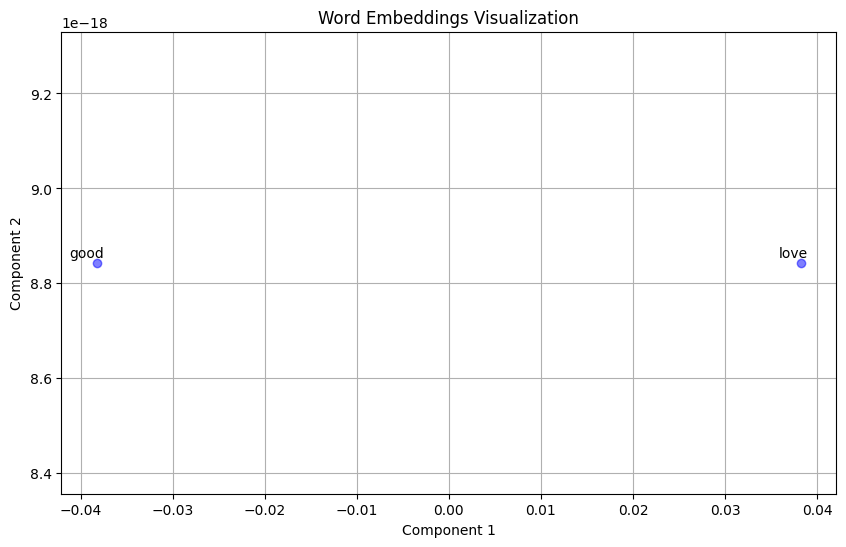

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_embeddings(model, words):
    """
    Visualize word embeddings using PCA.
    """
    words_in_vocab = [word for word in words if word in model.wv]
    word_vectors = [model.wv[word] for word in words_in_vocab]

    # Check if there are enough features for PCA
    if len(word_vectors[0]) <= 1:
        print("Cannot perform PCA with less than 2 features.")
        return

    # Determine the number of components based on the data
    n_components = min(len(words_in_vocab), len(word_vectors[0]))

    # Perform PCA with the determined number of components
    coordinates = PCA(n_components=n_components).fit_transform(word_vectors)

    plt.figure(figsize=(10, 6))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], marker='o', c='blue', alpha=0.5)
    for i, word in enumerate(words_in_vocab):
        plt.annotate(word, xy=(coordinates[i, 0], coordinates[i, 1]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('Word Embeddings Visualization')
    plt.grid(True)
    plt.show()

# Sample words to visualize
words_to_visualize = ['cinema', 'stuff', 'love', 'good']

# Plot word embeddings
plot_embeddings(model, words_to_visualize)


## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.


In [ ]:
# The GitHub link of your final csv file

# Link: https://github.com/chandanareddy1201/INFO-5731---Computational-Methods-for-Information-Systems/blob/main/sentimental_analysis.csv



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


All reviews saved to 'reviews_all.csv'.


# Mandatory Question

Provide your thoughts on the assignment. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
# Type your answer
#i have changed my dataset for this assignment, as my dataset from past assignment has no reviews it was unable to predict sentimental analysis.
#its challenging